# Algorithm Implmentation

#### Notes


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from IPython.display import Image

#### Project Links
* [Paper](https://arxiv.org/pdf/1506.02142.pdf)
* [Appendix](https://arxiv.org/pdf/1506.02157.pdf)
* [Authors' GitHub Repository](https://github.com/yaringal/DropoutUncertaintyCaffeModels)

In [2]:
# Read h5 file and format as a Pandas data frame
def read_h5_file(filename):
#     filename = 'test.h5'
    f = h5py.File(filename, 'r')
    data = [v for r in list(f['data']) for v in r]
    label = [v for r in list(f['label']) for v in r]
    return pd.DataFrame({'data': data, 'label': label})
    
# f = h5py.File('train.h5', 'r')
# List all groups
# print("Keys: %s" % f.keys())
# a_group_key = list(f.keys())[0]
# print(list(f.keys()))
# print(list(f['data']))
# print("-")
# print(list(f['label']))
# print(list(f))
# Get the data
# data = list(f[a_group_key])

train = read_h5_file('train.h5')
test = read_h5_file('test.h5')

In [3]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 2 columns):
data     275 non-null float64
label    275 non-null float64
dtypes: float64(2)
memory usage: 4.4 KB
None


,data,label
0,-1.727438,0.073381
1,-1.718201,0.176061
2,-1.708963,0.381420
3,-1.699725,0.381420
4,-1.690488,0.484099


In [4]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
data     100 non-null float64
label    100 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB
None


,data,label
0,-1.570398,-0.645374
1,-1.561161,-0.645374
2,-1.551923,-0.645374
3,-1.542685,-0.645374
4,-1.533448,-0.337336


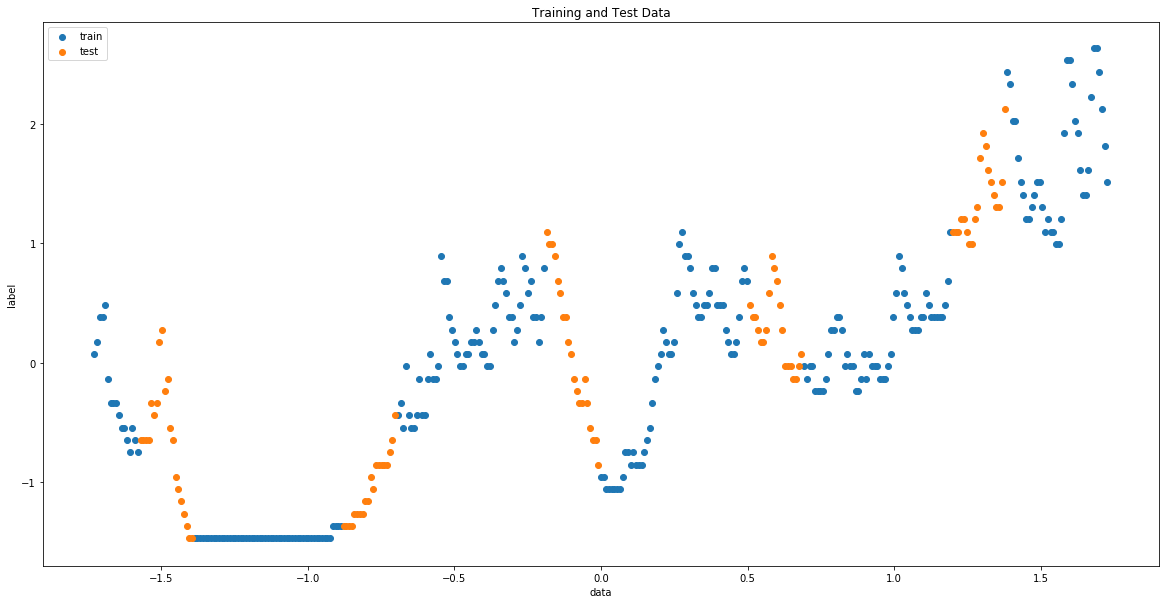

In [5]:
# Plot Training and Test Data
plt.figure(figsize=(20,10))
plt.scatter(train['data'], train['label'], label='train')
plt.scatter(test['data'], test['label'], label='test')
plt.xlabel('data')
plt.ylabel('label')
plt.title('Training and Test Data')
plt.legend()
plt.show()

#### Model Specifications from Paper
- ReLU Network
- 5 hidden layers
- 1024 hidden units in each layer
- Base learning rate 5e-3
- Weight decay 5e-7
- Otherwise, use the same parameters as the CO2 model:
- Stochastic gradient descent optimizer (run for 1,000,000 iterations / until convergence)
- Learning rate policy base:  lr * (1 + gamma * item)^-p
- Gamma = 0.0001, p = 0.25, momentum = 0.9
- Initialize the bias at 0
- Initialize weights uniformly from [-sqrt(3/fan-in), sqrt(3/fan-in)]
- No mini-batch optimization used, since the data is fairly small and with high frequencies
- Experimented with dropout probabilities of 0.1 and 0.2, but in the end, they both had about the same results, so it probably doesn’t matter that much
- However, it could be worth trying both on this model and see how the results change (if they do at all)
- Used T = 1000 forward iterations to estimate the uncertainty for drawing purposes
- However, they claim they could have gotten reasonable estimates using only T = 10
- Loss function = Euclidean loss


In [16]:
# Fit model according to specification in paper
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD
import keras.backend as K
from keras.callbacks import Callback

full = train.append(test)

# Euclidean loss function--obtained from:
# http://www.riptutorial.com/keras/example/32022/euclidean-distance-loss
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Based off of examples from:
# 1. https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
# 2. https://keras.io/getting-started/sequential-model-guide/#compilation

# Create NN dropout model
def create_model():
    # Create model
    model = Sequential()
    # Layer 1
    model.add(Dense(1024, input_dim=1, kernel_initializer='lecun_uniform', activation='relu'))
    model.add(Dropout(0.1))
    # Layer 2
    model.add(Dense(1024, kernel_initializer='lecun_uniform', activation='relu'))
    model.add(Dropout(0.1))
    # Layer 3
    model.add(Dense(1024, kernel_initializer='lecun_uniform', activation='relu'))
    model.add(Dropout(0.1))
    # Layer 4
    model.add(Dense(1024, kernel_initializer='lecun_uniform', activation='relu'))
    model.add(Dropout(0.1))
    # Layer 5
    model.add(Dense(1, kernel_initializer='lecun_uniform'))
    
    # Compile model
    sgd = SGD(lr=5e-3, momentum=0.9, decay=5e-7, nesterov=False)
    model.compile(loss=euclidean_distance_loss, optimizer=sgd)
    return model

# Save predictions from every epoch
# Code from: https://stackoverflow.com/questions/36895627/python-keras-creating-a-callback-with-one-prediction-for-each-epoch?noredirect=1&lq=1
class prediction_history(Callback):
    def __init__(self):
        self.predhis = []
    def on_epoch_end(self, epoch, logs={}):
        self.predhis.append(model.predict(full['data']))

In [7]:
# Train the model, iterating on the data in batches of 32 
nepochs = 1000
model = create_model()
# model.fit(x=train['data'], y=train['label'], epochs=1000, batch_size=32)

#Calling the subclass
predictions=prediction_history()

#Executing the model.fit of the neural network
model.fit(x=train['data'], y=train['label'], epochs=nepochs, batch_size=32, callbacks=[predictions])

#Printing the prediction history
# print(predictions.predhis)

Epoch 1/1000
275/275 [==============================] - 1s 2ms/step - loss: 0.7161
Epoch 2/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.6854
Epoch 3/1000
275/275 [==============================] - 0s 936us/step - loss: 0.6174
Epoch 4/1000
275/275 [==============================] - 0s 927us/step - loss: 0.5835
Epoch 5/1000
275/275 [==============================] - 0s 925us/step - loss: 0.6385
Epoch 6/1000
275/275 [==============================] - 0s 939us/step - loss: 0.5807
Epoch 7/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5725
Epoch 8/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5942
Epoch 9/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5910
Epoch 10/1000
275/275 [==============================] - 0s 998us/step - loss: 0.5702
Epoch 11/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5994
Epoch 12/1000
275/275 [==============================] - 0s 949us/step - lo

275/275 [==============================] - 0s 1ms/step - loss: 0.4979
Epoch 98/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.4946
Epoch 99/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.4982
Epoch 100/1000
275/275 [==============================] - 0s 985us/step - loss: 0.4963
Epoch 101/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5016
Epoch 102/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.4955
Epoch 103/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.4848
Epoch 104/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5620
Epoch 105/1000
275/275 [==============================] - 0s 989us/step - loss: 0.5551
Epoch 106/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5259
Epoch 107/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5012
Epoch 108/1000
275/275 [==============================] - 0s 1ms/step - loss: 

275/275 [==============================] - 0s 917us/step - loss: 0.3451
Epoch 193/1000
275/275 [==============================] - 0s 922us/step - loss: 0.3357
Epoch 194/1000
275/275 [==============================] - 0s 905us/step - loss: 0.3326
Epoch 195/1000
275/275 [==============================] - 0s 922us/step - loss: 0.3123
Epoch 196/1000
275/275 [==============================] - 0s 912us/step - loss: 0.3387
Epoch 197/1000
275/275 [==============================] - 0s 901us/step - loss: 0.3593
Epoch 198/1000
275/275 [==============================] - 0s 919us/step - loss: 0.3068
Epoch 199/1000
275/275 [==============================] - 0s 911us/step - loss: 0.3204
Epoch 200/1000
275/275 [==============================] - 0s 914us/step - loss: 0.2977
Epoch 201/1000
275/275 [==============================] - 0s 937us/step - loss: 0.2826
Epoch 202/1000
275/275 [==============================] - 0s 931us/step - loss: 0.2903
Epoch 203/1000
275/275 [==============================] - 

275/275 [==============================] - 0s 1ms/step - loss: 0.2598
Epoch 384/1000
275/275 [==============================] - 0s 949us/step - loss: 0.2494
Epoch 385/1000
275/275 [==============================] - 0s 964us/step - loss: 0.2727
Epoch 386/1000
275/275 [==============================] - 0s 968us/step - loss: 0.2633
Epoch 387/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2835
Epoch 388/1000
275/275 [==============================] - 0s 965us/step - loss: 0.2632
Epoch 389/1000
275/275 [==============================] - 0s 986us/step - loss: 0.2718
Epoch 390/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2538
Epoch 391/1000
275/275 [==============================] - 0s 967us/step - loss: 0.2526
Epoch 392/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2541
Epoch 393/1000
275/275 [==============================] - 0s 964us/step - loss: 0.2437
Epoch 394/1000
275/275 [==============================] - 0s 960us

275/275 [==============================] - 0s 971us/step - loss: 0.2229
Epoch 573/1000
275/275 [==============================] - 0s 950us/step - loss: 0.2303
Epoch 574/1000
275/275 [==============================] - 0s 931us/step - loss: 0.2309
Epoch 575/1000
275/275 [==============================] - 0s 945us/step - loss: 0.2321
Epoch 576/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2331
Epoch 577/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2440A: 0s - loss: 0.2
Epoch 578/1000
275/275 [==============================] - 0s 988us/step - loss: 0.2289
Epoch 579/1000
275/275 [==============================] - 0s 1000us/step - loss: 0.2577
Epoch 580/1000
275/275 [==============================] - 0s 955us/step - loss: 0.2506
Epoch 581/1000
275/275 [==============================] - 0s 975us/step - loss: 0.2428
Epoch 582/1000
275/275 [==============================] - 0s 951us/step - loss: 0.2448
Epoch 583/1000
275/275 [====================

275/275 [==============================] - 0s 1ms/step - loss: 0.2239
Epoch 762/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2349
Epoch 763/1000
275/275 [==============================] - 0s 999us/step - loss: 0.2203
Epoch 764/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2289
Epoch 765/1000
275/275 [==============================] - 0s 991us/step - loss: 0.2275
Epoch 766/1000
275/275 [==============================] - 0s 999us/step - loss: 0.2390
Epoch 767/1000
275/275 [==============================] - 0s 956us/step - loss: 0.2183
Epoch 768/1000
275/275 [==============================] - 0s 938us/step - loss: 0.2047
Epoch 769/1000
275/275 [==============================] - 0s 994us/step - loss: 0.2306
Epoch 770/1000
275/275 [==============================] - 0s 979us/step - loss: 0.2300
Epoch 771/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2351
Epoch 772/1000
275/275 [==============================] - 0s 964us

275/275 [==============================] - 0s 1ms/step - loss: 0.2408
Epoch 953/1000
275/275 [==============================] - 0s 984us/step - loss: 0.2158
Epoch 954/1000
275/275 [==============================] - 0s 997us/step - loss: 0.2227
Epoch 955/1000
275/275 [==============================] - 0s 2ms/step - loss: 0.2239
Epoch 956/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2143
Epoch 957/1000
275/275 [==============================] - 0s 992us/step - loss: 0.2161
Epoch 958/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2514
Epoch 959/1000
275/275 [==============================] - 0s 968us/step - loss: 0.2439
Epoch 960/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2361
Epoch 961/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2401
Epoch 962/1000
275/275 [==============================] - 0s 971us/step - loss: 0.2327
Epoch 963/1000
275/275 [==============================] - 0s 975us/ste

In [8]:
len(predictions.predhis[0])

375

In [9]:
# train.append(test).shape
# full = train.append(test)
full['pred'] = model.predict(full['data'])

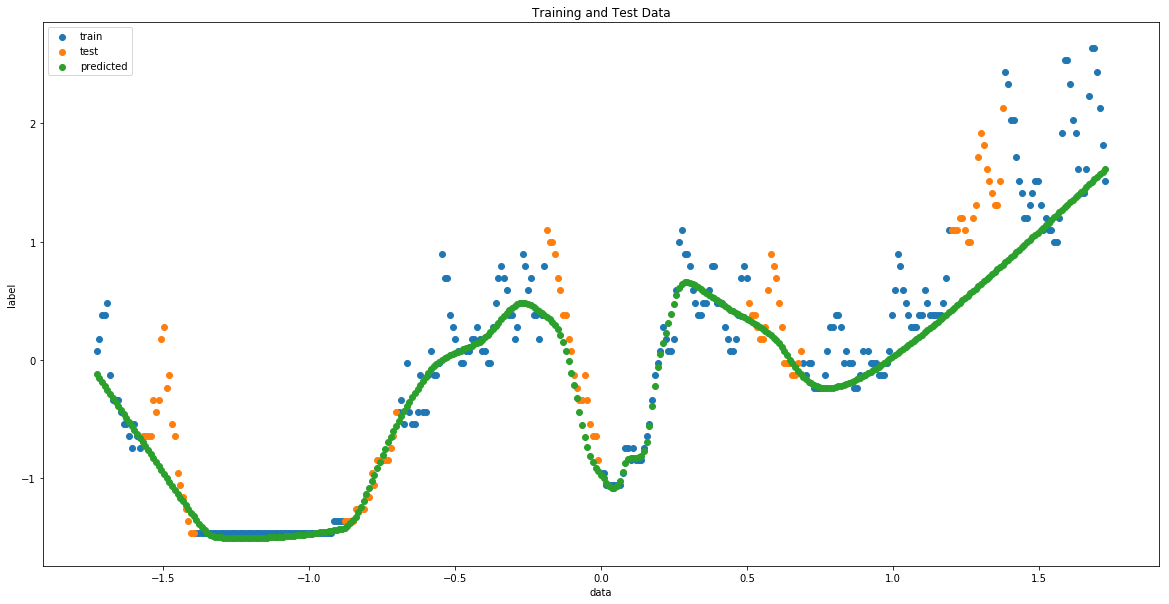

In [10]:
# Plot the predicted vs. actual values
plt.figure(figsize=(20,10))
plt.scatter(train['data'], train['label'], label='train')
plt.scatter(test['data'], test['label'], label='test')
plt.scatter(full['data'], full['pred'], label='predicted')
plt.xlabel('data')
plt.ylabel('label')
plt.title('Training and Test Data')
plt.legend()
plt.show()

In [11]:
# Reformat recorded predictions into a list, where each element is a numpy array
# of the predictions for a given variable from every pass
value_preds = []
for i in range(len(predictions.predhis[0])):
    value_pred_set = []
    for j in range(len(predictions.predhis)):
        value_pred_set.append(np.array(predictions.predhis[j][i]))
    value_preds.append(np.array(value_pred_set))

#### Formula for Variance
Using the following formulas from the paper to compute the variance (found in section 4 of the paper):

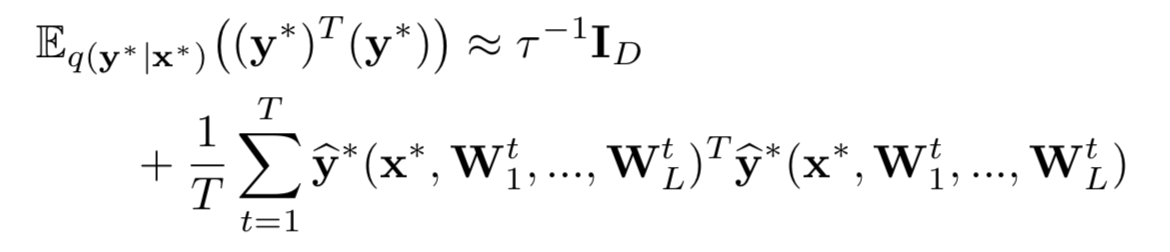

In [38]:
Image(filename='Images/Expectation.png')

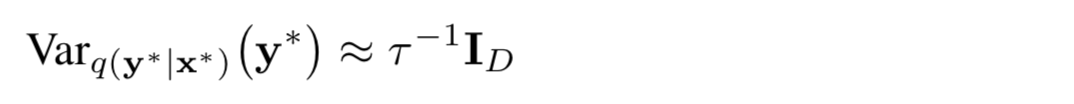

In [39]:
Image(filename='Images/Variance 1.png')

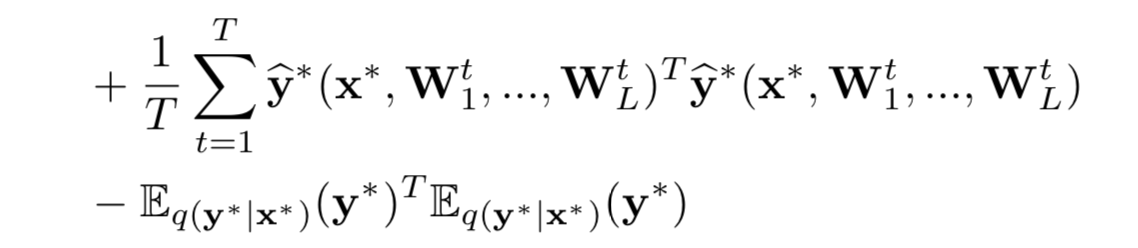

In [40]:
Image(filename='Images/Variance 2.png')

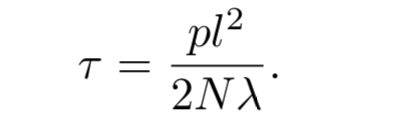

In [41]:
Image(filename='Images/Tau.png')

In [31]:
# Compute the variance for each observation
def E(tau_inv, yhat):
    return tau_inv + 1 / len(yhat) * np.sum(np.dot(yhat.T, yhat))

def VAR(tau_inv, yhat):
    return tau_inv + 1 / len(yhat) * np.sum(np.dot(yhat.T, yhat)) - E(tau_inv, yhat)**2

# Compute 2 * SD for the data point
def two_SD(tau_inv, yhat):
    return 2 * np.sqrt(VAR(tau_inv, yhat))

N = len(full)
lambda_val = 5e-7
p = 0.25
l = 1 # Random, user-chosen value
tau_inv = (2 * N * lambda_val) / (p * l**2)

# E(tau_inv, value_preds[0])
# # np.sum(np.dot(value_preds[0].T, value_preds[0]))
# VAR(tau_inv, value_preds[0])

In [33]:
# Get 2-sigma envelope
# full_pred = list(full['pred'])
# upper = [full_pred[i] + two_SD(tau_inv, value_preds[i]) for i in range(len(full_pred))]
# upper

a = []
for i in range(len(value_preds)):
# for i in range(1):
#     print(np.mean(value_preds[i]))
#     print("tau_inv:", tau_inv)
#     print("value_preds[i]:", len(value_preds[i]))
#     print("E(tau_inv, yhat):", E(tau_inv, value_preds[i]))
#     print("VAR(tau_inv, value_preds[i]):", VAR(tau_inv, value_preds[i]))
#     print('-' * 50)
    a.append(VAR(tau_inv, value_preds[i]))
#     print(VAR(tau_inv, value_preds[i]))

pd.Series(a).describe()

count    3.750000e+02
mean    -2.068917e+32
std      4.893268e+32
min     -1.361129e+33
25%     -5.002500e-04
50%      1.497750e-03
75%      1.497750e-03
max      3.487750e-03
dtype: float64

Problem above: variances are negative in some cases